In [15]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from konlpy.tag import Okt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
from collections import Counter
import sklearn.metrics as metrics

## 데이터 로드

In [11]:
data_origin = pd.read_csv("data/hate_speech_large.csv")
data_origin.columns = ["comments", "label"]
print(data_origin.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0   90000
1      1  100000


In [16]:
data = pd.read_csv("data/hate_speech_large.csv")
data.columns = ["comments", "label"]
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1


In [17]:
print("댓글 개수 :",len(data)) # 댓글 개수 출력

댓글 개수 : 190000


(0.0, 110000.0)

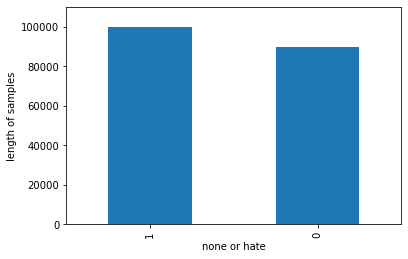

In [18]:
data['label'].value_counts().plot(kind = 'bar')
plt.ylabel('length of samples')
plt.xlabel('none or hate')
plt.ylim(top = 110000)

## 데이터 정제

In [19]:
data['label'] = np.where(data['label'] == 0, 1, 0)

### 댓글의 중복 여부 확인

In [20]:
data['comments'].nunique(), data['label'].nunique()

(187142, 2)

In [21]:
data.drop_duplicates(subset=['comments'], inplace=True) # 중복 코멘트 제거
data.shape

(187143, 2)

In [22]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 187143


#### 레이블 값의 분포

(0.0, 110000.0)

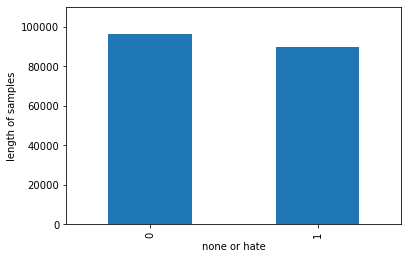

In [96]:
data['label'].value_counts().plot(kind = 'bar')
plt.ylabel('length of samples')
plt.xlabel('none or hate')
plt.ylim(top = 110000)

In [24]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97223
1      1  89920


### Null 값 제거

In [25]:
print(data.isnull().values.any())

True


In [26]:
print(data.isnull().sum())

comments    1
label       0
dtype: int64


In [27]:
data.loc[data.comments.isnull()]

,comments,label
7807,NaN,0


In [28]:
data = data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [29]:
print(len(data))

187142


### 한글, 공백 제외 전처리

In [30]:
data['comments'] = data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1
3,착한아이임당 용지 덮고,1
4,진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영...,0


In [31]:
data['comments'] = data['comments'].str.strip()
data['comments'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

comments    1021
label          0
dtype: int64


In [32]:
data = data.dropna(how = 'any')
print(len(data))

186121


### 데이터 분리

In [33]:
train_data = data[:150000]
test_data = data[150000:]

train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [115]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

## EDA

### 워드클라우드
* 긍정/부정 댓글에서 빈도수가 가장 높은 명사들을 시각화

명사 추출 함수

In [40]:
def get_nouns(data, label):
    subset = data[data['label'] == label]
    text = subset['comments']
    
    morphs = []
    for sentence in text:
        morphs.append(mecab.pos(sentence))

    nouns = []
    for morph in morphs:
        for word, tag in morph:
            if tag in ['Noun']:
                nouns.append(word)
    
    count = Counter(nouns)
    words = dict(count.most_common())
    
    return words

positive = get_nouns(train_data, 0)
negative = get_nouns(train_data, 1)

워드 클라우드 생성 함수

In [43]:
def generate_word_cloud(data, img, title, cmap):
    clean_mask = np.array(Image.open(str(img) + ".png"))
    clean_mask = clean_mask[:,:,1]

    wc = WordCloud(font_path ='NanumGothic.ttf', 
                   background_color ="black",
                   max_words = 2000,
                   mask = clean_mask,
                   stopwords = stopwords)

    wc.generate(" ".join(data))
    plt.figure(figsize = (20, 10))
    plt.axis("off")
    plt.title(title, fontsize = 30)
    plt.imshow(wc.recolor(colormap = cmap, random_state = 17), alpha = 0.98)
    plt.savefig(title + ".png")

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
generate_word_cloud(positive, "safe-zone", "긍정 댓글 명사 빈도", "viridis")
generate_word_cloud(negative, "anger", "부정 댓글 명사 빈도", "hot")

FileNotFoundError: ignored

## 토큰화

In [116]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [117]:
okt=Okt()
X_train = []
for sentence in train_data['comments']:
    temp_X = []
    temp_X = okt.morphs(sentence,) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [118]:
X_train[0]

['정말', '재밌다', '연기', '좋고', '디카프리오', '짱']

In [119]:
print(X_train[0])

['정말', '재밌다', '연기', '좋고', '디카프리오', '짱']


In [120]:
X_test = []
for sentence in test_data['comments']:
    temp_X = []
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

NameError: name 'mecab' is not defined

In [52]:
print(X_test[0])

['문채원', '짱', '너무나', '사랑', '스럽', '고', '귀엽', '고', '문채원', '매력', '푹', '빠져', '보', '세요']


In [169]:
with open("data/khaiii_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
    
with open("data/khaiii_test.pkl", "wb") as f:
     pickle.dump(X_test, f)

# 여기서 시작 ---------------------------------------------------------

In [38]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from konlpy.tag import Okt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [39]:
with open("data/okt_train.pkl", "rb") as f:
    X_train = pickle.load(f)
    
with open("data/okt_test.pkl", "rb") as f:
    X_test = pickle.load(f)

In [40]:
print(len(X_test),len(X_train))

36121 150000


In [41]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

## 정수 인코딩

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [43]:
print(len(tokenizer.word_index))

56246


In [44]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56246
등장 빈도가 2번 이하인 희귀 단어의 수: 31118
단어 집합에서 희귀 단어의 비율: 55.32482309853145
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.119818367596178


In [45]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 25130


In [46]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [47]:
print(X_train[:3])

[[21, 17, 54, 8, 3090, 130], [21036, 216, 13736, 1235, 2155, 3000, 305, 1069, 9532, 305], [368, 6, 320, 447, 51, 67, 698, 98, 10]]


In [48]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [49]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(drop_train)

15

In [50]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

149985
149985


## 패딩

리뷰의 최대 길이 : 468
리뷰의 평균 길이 : 12.065133179984665


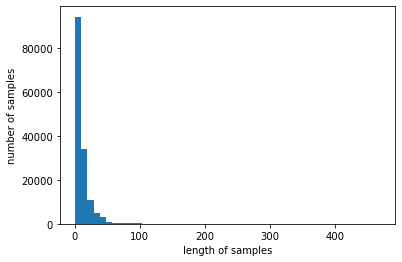

In [51]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [52]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [53]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.35716905023835


In [54]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [55]:
X_train.shape

(149985, 50)

In [57]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         21,   17,   54,    8, 3090,  130])

In [75]:
import collections, numpy

In [98]:
train_y= collections.Counter(y_train)
test_y = collections.Counter(y_test)
print(train_y)
print(test_y)

Counter({0: 78008, 1: 71977})
Counter({0: 18550, 1: 17571})


In [107]:
df = pd.DataFrame([[78008, 71977], [18550, 17571]],index = ['Train', 'Test'], columns = [0, 1])
df

,0,1
Train,78008,71977
Test,18550,17571


(0.0, 110000.0)

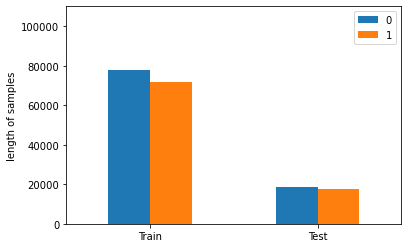

In [113]:
df.plot(kind='bar')
plt.ylabel('length of samples')
plt.xticks(rotation = 0)
plt.ylim(top = 110000)

(0.0, 110000.0)

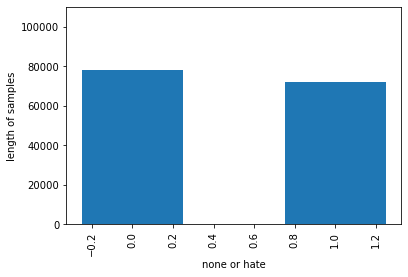

In [97]:
plt.bar(x1,y1,width=0.5)
plt.xticks(rotation=90)
plt.ylabel('length of samples')
plt.xlabel('none or hate')
plt.ylim(top = 110000)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

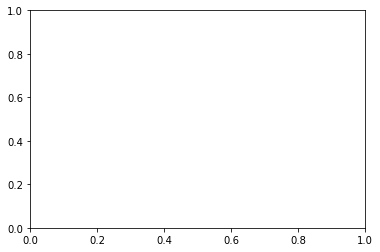

In [99]:
from matplotlib import pyplot as plt

topics = [0,1]
value_a = [78008,71977]
value_b = [18550,17571]

def create_x(t, w, n, d):
    return [t*x + w*n for x in range(d)]

value_a_x = create_x(2, 0.8, 1, 5)
value_b_x = create_x(2, 0.8, 2, 5)

ax = plt.subplot()
ax.bar(value_a_x, value_a)
ax.bar(value_b_x, value_b)

middle_x = [(a+b)/2 for (a,b) in zip(value_a_x, value_b_x)]
ax.set_xticks(middle_x)
ax.set_xticklabels(topics)

plt.show()

In [ ]:
data['label'].value_counts().plot(kind = 'bar')
plt.ylim(top = 110000)

In [56]:
len(X_test)

36121

## CNN으로 악성 댓글 분류

In [59]:
from tensorflow.keras.layers import Embedding, Activation, Input,Conv2D, Flatten, Reshape, Dense, Dropout, LSTM, SimpleRNN,Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [241]:
sequence_length = max_len
num_features = vocab_size
embedding_dimension = 100

In [114]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2513000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,630,377
Trainable params: 2,630,377
Non-trainable params: 0
_________________________________________________________________


In [242]:
# Basic CNN using 1D convolution and pooling(Known as "temperal convoulution")
sequence_length = max_len
num_features = vocab_size
embedding_dimension = 100

model = Sequential()
model.add(Embedding(input_dim = num_features ,
                    output_dim = embedding_dimension, 
                    input_length = max_len))
model.add(Conv1D(filters = 50, kernel_size = 5, strides = 1, padding = 'valid'))
model.add(MaxPooling1D(2, padding = 'valid'))
model.add(Flatten())
model.add(Dense(10,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 50, 100)           2513000   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 46, 50)            25050     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 23, 50)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1150)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                11510     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 11        
Total params: 2,549,571
Trainable params: 2,549,571
Non-trainable params: 0
___________________________________________

In [243]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('okt_CNN1D_.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [244]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1908 - acc: 0.9203
Epoch 00001: val_acc improved from -inf to 0.93703, saving model to okt_CNN1D_.h5
2000/2000 [==============================] - 63s 32ms/step - loss: 0.1908 - acc: 0.9204 - val_loss: 0.1609 - val_acc: 0.9370
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9450
Epoch 00002: val_acc improved from 0.93703 to 0.94023, saving model to okt_CNN1D_.h5
2000/2000 [==============================] - 65s 32ms/step - loss: 0.1424 - acc: 0.9451 - val_loss: 0.1553 - val_acc: 0.9402
Epoch 3/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1290 - acc: 0.9511
Epoch 00003: val_acc improved from 0.94023 to 0.94059, saving model to okt_CNN1D_.h5
2000/2000 [==============================] - 64s 32ms/step - loss: 0.1290 - acc: 0.9511 - val_loss: 0.1515 - val_acc: 0.9406
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1156 - acc: 0.9566
E

In [60]:
loaded_model = load_model('okt_CNN1D_.h5')
print("\n테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1129/1129 [==============================] - 4s 3ms/step - loss: 0.1487 - acc: 0.9427

테스트 정확도: 0.9427


In [61]:
pred = loaded_model.predict(X_test)
pred

array([[9.4511597e-06],
       [9.9998885e-01],
       [4.2025208e-02],
       ...,
       [8.9248383e-01],
       [4.4890010e-05],
       [1.0000000e+00]], dtype=float32)

In [62]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_true=y_test, y_pred=pred.round())

print(results)

[[17312  1238]
 [  831 16740]]


In [63]:
y_test_decode = []
for i in range(len(y_test)):
    if y_test[i] >= 0.5:
        y_test_decode.append(1)
    else:
        y_test_decode.append(0)
len(y_test_decode)
pred = model.predict(X_test)
pred_decode = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        pred_decode.append(1)
    else:
        pred_decode.append(0)
pred

NameError: name 'model' is not defined

In [ ]:
print('f1 : ',metrics.f1_score(y_test_decode, pred_decode, average='macro'))
print('recall : ', metrics.recall_score(y_test_decode,pred_decode,average='macro'))
print('precision : ',metrics.precision_score(y_test_decode,pred_decode,average='macro'))
print('accuracy', metrics.accuracy_score(y_test_decode, pred_decode,))

In [64]:
def sentiment_predict(new_sentence):
    sent = new_sentence
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{}: {:.2f}% --.\n".format(sent, score * 100))
    else:
        print("{}: {:.2f}% ++.\n".format(sent, (1 - score) * 100))

In [66]:
for sentence in train_data['comments'][:100]:
    sentiment_predict(sentence)

정말 재밌다 연기도 좋고 디카프리오 짱: 99.99% ++.

심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ: 98.47% ++.

하지만 이니후빨러들은 이런거 관심 하나도 없음: 76.93% --.

착한아이임당  용지 덮고: 93.75% --.

진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영화에서 예술성과 철학만 찾고있으니 영화 볼때 평점 안보고 봅니다: 100.00% ++.

조원진이 비례대표나 경북에서 공천 못받고도 입다물면 친중질히던거 이해할게: 99.95% --.

후 쩔었다: 88.26% ++.

오랜만에 휴가내서 조카들 데리고 보고나왔어요  조카들이 너무 좋아해서 평점 점 남겨용: 100.00% ++.

제목만 보고도 더러운 머리스탈 떠올랐다 이름보다 아 그더런새끼겠지 이랬다니까: 98.44% --.

중국 공산당 보는것 같다: 98.84% --.

별점별점별점별점별점: 100.00% ++.

조센징들의 한계지 민족성 자체가 동남아나 아프리카 토인이랑 다르게없음 ㅋㅋㅋ: 93.21% --.

오 좋은데요 사랑이 넘치네요: 95.68% ++.

ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 아니 북한이 그렇게 좋으면 보따리 싸가서 살지 진짜 ㅋㅋㅋㅋㅋ: 99.47% --.

야기라유야의 매력을 알게된영화: 99.75% ++.

노루엣이 개나 ㅋㅋㅋㅋㅋㅋㅋㅋ: 97.76% --.

저새끼는 아무 것도 한게 없는데 목소리만 깔아서지지율 높은 미스테리한 인간임: 99.81% --.

액션을 정말 이렇게 맛깔나게 표현할수가 신선하고 멋지다: 100.00% ++.

근데이전에박선영도 단식좀했는데진짜 쩔게마름ㄷㄷ진짜좌파역겹다진짜존나게: 99.96% --.

엄마의 아픔이 고스란히 전해지는것 같아 슬펐어요: 99.92% ++.

대단한 영화이긴 한데 도대체 남자 쌍둥이 예지자는 왜 필요한거지 어차피 아가사가 제일 잘하고 둘이 놓치는 것도 아가사 혼자서 다 잡아낼 정도인데 한명이면 너무 쓸쓸할거같았나: 96.92% ++.

부모님에 대한 생각

KeyboardInterrupt: 

In [65]:
for sentence in test_data['comments'][:100]:
    sentiment_predict(sentence)

문채원 짱 너무나 사랑스럽고 귀엽고 문채원의 매력에 푹 빠져보세요: 100.00% ++.

익명 육사 조지는거: 100.00% --.

재미만있구만: 95.80% ++.

내가 지인들에게 가장 추천하고픈 영화: 99.67% ++.

가슴에 사무치게 따뜻한 영화ㅋ: 99.85% ++.

이건뭐 우리 강지환씨가 다 살려주네 그려차도남 현기준의 무한매력에 빠져있느라 다른캐릭터는눈에 들어오지도 않았음ㅋㅋ어쨌든 만화같은 이야기 넘 재밌게 봄: 100.00% ++.

무능보다 거짓말이래 ㅋㅋㅋ 탈당했다가 복당 짓은 거짓말이냐 무능이냐 저런 의원들  상황에따라 적이 바뀌고 말이 바뀌는 사람들  저러는 이유는 다른거 없다 지가 정치 계속하고 싶고 의원 계속하고 싶기 때문이지 속은 주판말 퉁기면서 겉으론 입바른 소리: 100.00% --.

강남권서울멋쟁이 ㄱㅅ: 98.72% --.

의사가 일부러 그런것도 아니고 저정도 고수들만 의사하라고 하면 당장 국민이 더 불편함 어쩔 수 없는거임: 99.72% --.

진중권 ㅇㅂ: 99.99% --.

서울 안살면 대부분  전화번호 안받음: 99.03% --.

임기말쯤 터질듯결국 바둑이랑기: 91.34% --.

김수현의 불륜에는 뭔가 철학이 있더라: 96.42% ++.

사랑에눈멀어눈에뵈는게없는게아니라 사랑을 기성세대의 틀로 억압한 결과지 무식아: 50.20% --.

익명 중일러 헬조셴도 만만치않은듯: 100.00% --.

머가리폭도컷 아오 씨발ㅋㅋ 존나웃기노: 100.00% --.

오프리 윈프리 맞나: 93.19% --.

사랑을알아가는데필요한시간을잘말해주는영화: 99.99% ++.

이게 점짜리지: 96.65% ++.

나도 그러던데지들이 걸어놓고 갑자기 귀하는 해당지역 조사대상이 아니래 ㅋ: 99.69% --.

사무엘잭슨은 좀빼라 못봐주겠다: 82.47% ++.

제발 세컨더리 보이콧 해주세요: 89.27% --.

샤이니오빠들 사랑해요 지금은 빛나는 우리 샤이니 시대 진기종현기범민호태민 오빠 사랑해요: 99.99% 

KeyboardInterrupt: 